### Synopsis
This code plots the averaged SA-XPCS results for the temperature ramping (up and down).   
Need to run the analysis code to generate the `checkpoint.pickle` file prior to running the figure rendering code

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

Curve 1: q_scale=1.0600, i_scale=0.8870, chi2=0.0001
Curve 2: q_scale=1.1300, i_scale=0.7650, chi2=0.0001
Curve 3: q_scale=1.2600, i_scale=0.6340, chi2=0.0001
Curve 4: q_scale=1.4500, i_scale=0.5000, chi2=0.0001
Curve 5: q_scale=1.9800, i_scale=0.2970, chi2=0.0001
Curve 6: q_scale=3.4300, i_scale=0.1050, chi2=0.0000
Curve 7: q_scale=6.1300, i_scale=0.0170, chi2=0.0002
Curve 8: q_scale=10.1800, i_scale=0.0020, chi2=0.0004


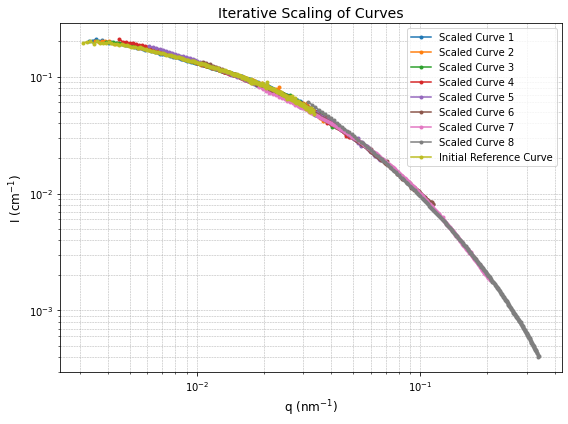

In [11]:

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    """
    Preprocess the data to remove non-positive values from q and I.
    Returns cleaned q and avg_data_list.
    """
    cleaned_data_list = []
    cleaned_ql_sta = []

    for curve in avg_data_list[0:-1]:
        q = ql_sta
        i = curve['saxs_1d']
        
        # Filter to ensure both q and I are positive
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})

    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the chi-squared metric for direct comparison
def chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y):
    """
    Calculate chi-squared directly comparing the reference curve with the scaled target curve.
    Formula: chi^2 = sum((O - E)^2 / E)
    """
    target_x = np.log10(target_x)
    target_y = np.log10(target_y)
    ref_x = np.log10(ref_x)
    ref_y = np.log10(ref_y)

    scaled_x = target_x + np.log10(q_scale)
    scaled_y = target_y + np.log10(i_scale)

    range_x_min = np.max([np.min(scaled_x), np.min(ref_x)])
    range_x_max = np.min([np.max(scaled_x), np.max(ref_x)])
    range_x_overlap = np.where((scaled_x > range_x_min) & (scaled_x < range_x_max))

    ref_y_inter = np.interp(scaled_x[range_x_overlap], ref_x, ref_y)

    chi2 = np.mean((scaled_y[range_x_overlap] - ref_y_inter) ** 2)

    return chi2

# Iteratively scale curves
def iterative_scaling(avg_data_list, ql_sta_cleaned):
    """
    Iteratively scale each curve in the dataset, using the previously scaled curve as the reference.
    Dynamically adjust the q_scale range based on the curve index.
    """
    ref_x = ql_sta_cleaned[0]
    ref_y = avg_data_list[0]['saxs_1d']

    scaling_results = []
    scaled_curves = []

    for i in range(1, len(avg_data_list)):  # Start from the second curve
        target_x = ql_sta_cleaned[i]
        target_y = avg_data_list[i]['saxs_1d']

        # Set dynamic q_scale range based on curve index
        if i <= 4:  # Curves 1–4
            q_scale_range = np.arange(0.5, 2.0, 0.01)
        elif i <= 6:  # Curves 5–6
            q_scale_range = np.arange(1.9, 4.2, 0.01)
        elif i == 7:  # Curve 7
            q_scale_range = np.arange(5.5, 7.0, 0.01)
        elif i == 8:  # Curve 8
            q_scale_range = np.arange(9.5, 11.0, 0.01)
        else:
            raise ValueError(f"Unexpected curve index: {i}")

        i_scale_range = np.arange(0.001, 1.5, 0.001)

        chi2_results = []
        for q_scale in q_scale_range:
            for i_scale in i_scale_range:
                chi2 = chi_squared_direct(q_scale, i_scale, ref_x, ref_y, target_x, target_y)
                chi2_results.append((q_scale, i_scale, chi2))

        best_q_scale, best_i_scale, min_chi2 = min(chi2_results, key=lambda x: x[2])
        scaling_results.append((i, best_q_scale, best_i_scale, min_chi2))

        scaled_x = target_x * best_q_scale
        scaled_y = target_y * best_i_scale
        scaled_curves.append((scaled_x, scaled_y))

        ref_x = scaled_x
        ref_y = scaled_y

    return scaling_results, scaled_curves

# Apply the iterative scaling method
scaling_results, scaled_curves = iterative_scaling(avg_ramp_up_cleaned, ql_sta_cleaned)

# Save the scaling results to a file
with open('iterative_scaling_results.txt', 'w') as f:
    for result in scaling_results:
        f.write(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}\n")

# Print the results
for result in scaling_results:
    print(f"Curve {result[0]}: q_scale={result[1]:.4f}, i_scale={result[2]:.4f}, chi2={result[3]:.4f}")

# Plot all the scaled curves
fig, ax = plt.subplots(figsize=(8, 6))
for i, (scaled_x, scaled_y) in enumerate(scaled_curves):
    ax.loglog(scaled_x, scaled_y, label=f'Scaled Curve {i+1}', marker='o', linestyle='-', markersize=3)

# Plot the initial reference curve
ref_x = ql_sta_cleaned[0]
ref_y = avg_ramp_up_cleaned[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Initial Reference Curve', marker='o', linestyle='-', markersize=3)

# Add labels, legend, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Iterative Scaling of Curves', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('iterative_scaling_plot.pdf')
plt.show()



Curve 1: Fitted Iq0 = 0.1949, Fitted x = 59.2742
Curve 2: Fitted Iq0 = 0.2198, Fitted x = 62.6895
Curve 3: Fitted Iq0 = 0.2540, Fitted x = 66.2649
Curve 4: Fitted Iq0 = 0.3035, Fitted x = 72.8190
Curve 5: Fitted Iq0 = 0.3883, Fitted x = 84.1585
Curve 6: Fitted Iq0 = 0.6189, Fitted x = 107.2572
Curve 7: Fitted Iq0 = 1.5260, Fitted x = 161.8022
Curve 8: Fitted Iq0 = 7.3338, Fitted x = 238.0908
Curve 9: Fitted Iq0 = 160.6682, Fitted x = 721.2847


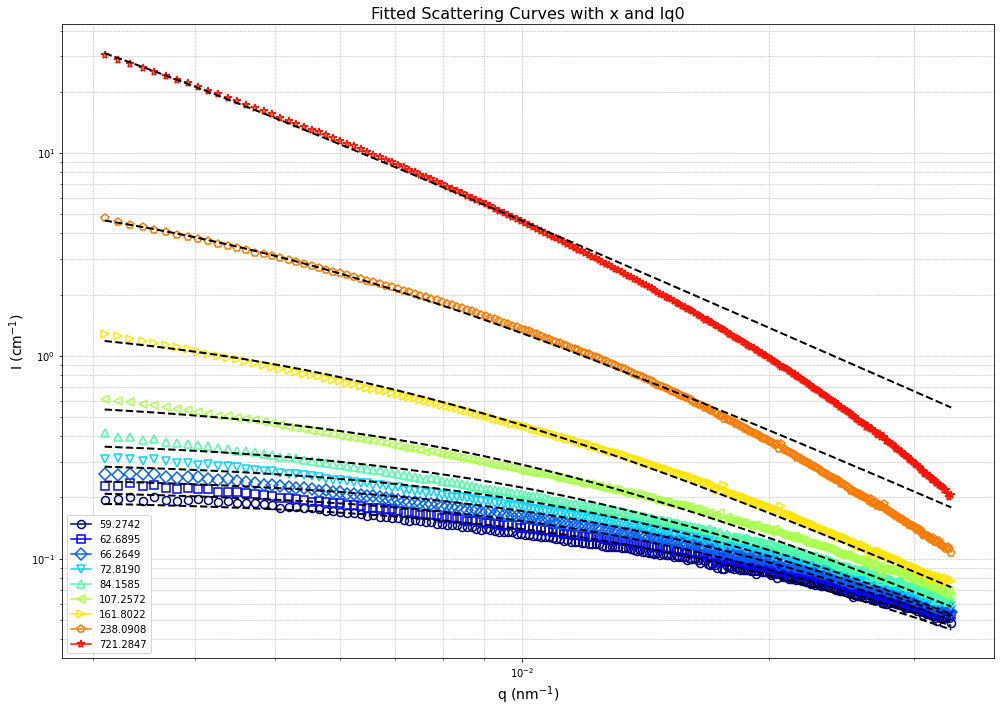

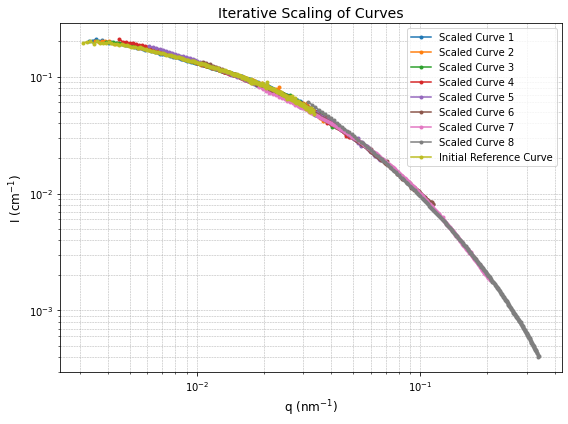

In [13]:


# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    cleaned_data_list = []
    cleaned_ql_sta = []

    for curve in avg_data_list[:-1]:  # Exclude the last curve
        q = ql_sta
        i = curve['saxs_1d']
        
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})

    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []
fitted_curves = []

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']

    # Fit the curve
    try:
        popt, pcov = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))

        # Generate the fitted curve
        fitted_I = scattering_fit(q, Iq0_fit, x_fit)
        fitted_curves.append((q, fitted_I))

        print(f"Curve {i+1}: Fitted Iq0 = {Iq0_fit:.4f}, Fitted x = {x_fit:.4f}")

    except RuntimeError as e:
        print(f"Curve {i+1}: Fitting failed - {str(e)}")

# Generate a colormap based on the number of curves
cmap = plt.get_cmap('jet')
total_curves = len(ql_sta_cleaned)
colors = [cmap(i / total_curves) for i in range(total_curves)]

# Define marker styles for the original curves
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']  # Variety of marker types

# Plot all the original and fitted curves
fig, ax = plt.subplots(figsize=(14, 10))  # Larger figure size

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    color = colors[i]  # Use colormap-based color
    marker = marker_styles[i % len(marker_styles)]  # Cycle through marker styles
    ax.loglog(
        q, 
        data['saxs_1d'], 
        marker, 
        label=f'{fitted_parameters[i][1]:.4f}', 
        color=color, 
        markersize=8, 
        markerfacecolor='none',  # Make the marker hollow
        markeredgewidth=1.5  # Thicker edge for visibility
    )

for i, (q, fitted_I) in enumerate(fitted_curves):
    ax.loglog(q, fitted_I, '--', color='black', linewidth=2)  # Always use red for the fitted line

# Add a legend with markers and x values
legend_elements = [
    Line2D(
        [0], [0], 
        marker=marker_styles[i % len(marker_styles)], 
        color=colors[i], 
        label=f'{fitted_parameters[i][1]:.4f}', 
        markersize=8, 
        markerfacecolor='none', 
        markeredgewidth=1.5
    )
    for i in range(len(fitted_parameters))
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Add labels, title, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=14)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=14)
ax.set_title('Fitted Scattering Curves with x and Iq0', fontsize=16)
ax.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


#---

# Plot all the scaled curves
fig, ax = plt.subplots(figsize=(8, 6))
for i, (scaled_x, scaled_y) in enumerate(scaled_curves):
    ax.loglog(scaled_x, scaled_y, label=f'Scaled Curve {i+1}', marker='o', linestyle='-', markersize=3)

# Plot the initial reference curve
ref_x = ql_sta_cleaned[0]
ref_y = avg_ramp_up_cleaned[0]['saxs_1d']
ax.loglog(ref_x, ref_y, label='Initial Reference Curve', marker='o', linestyle='-', markersize=3)

# Add labels, legend, and grid
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
ax.set_title('Iterative Scaling of Curves', fontsize=14)
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('iterative_scaling_plot.pdf')
plt.show()


/tmp/ipykernel_2267088/361112708.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


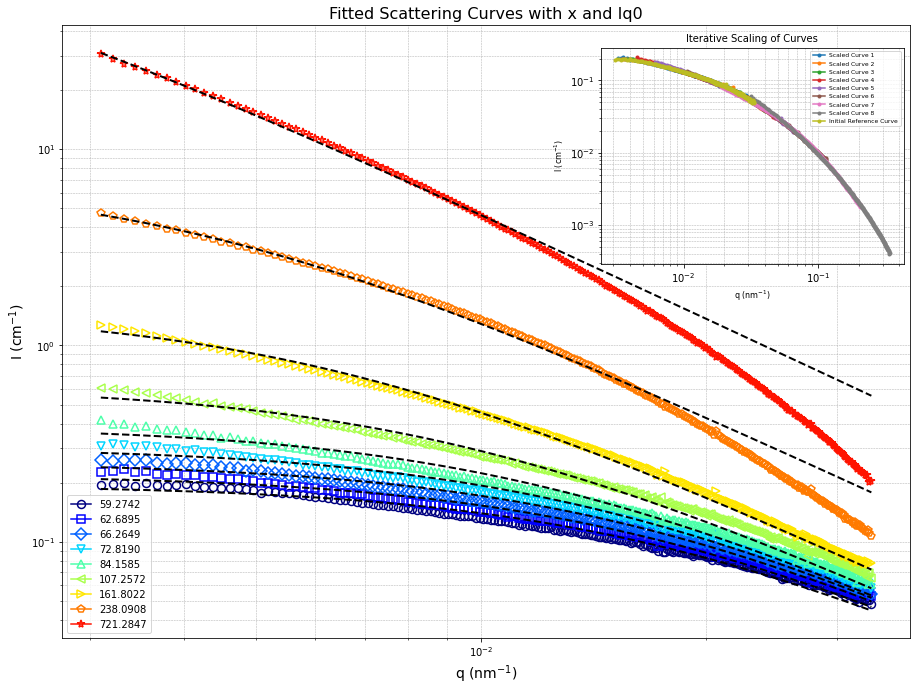

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and remove non-positive values
def preprocess_data(avg_data_list, ql_sta):
    cleaned_data_list = []
    cleaned_ql_sta = []
    for curve in avg_data_list[:-1]:
        q = ql_sta
        i = curve['saxs_1d']
        valid_indices = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices]
        cleaned_i = i[valid_indices]
        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})
    return cleaned_data_list, cleaned_ql_sta

# Preprocess the data
avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

# Define the scattering fit function
def scattering_fit(q, Iq0, x):
    b = 1.7815
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []
fitted_curves = []
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']
    try:
        popt, _ = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))
        fitted_curves.append((q, scattering_fit(q, Iq0_fit, x_fit)))
    except RuntimeError:
        continue

# Generate colormap for curves
cmap = plt.get_cmap('jet')
total_curves = len(ql_sta_cleaned)
colors = [cmap(i / total_curves) for i in range(total_curves)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

# Main figure
fig, ax = plt.subplots(figsize=(14, 10))
fig.subplots_adjust(left=0.1,right=0.105, top=0.27)

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    ax.loglog(q, data['saxs_1d'], marker_styles[i % len(marker_styles)], label=f'{fitted_parameters[i][1]:.4f}', 
               color=colors[i], markersize=8, markerfacecolor='none', markeredgewidth=1.5)
for i, (q, fitted_I) in enumerate(fitted_curves):
    ax.loglog(q, fitted_I, '--', color='black', linewidth=2)

# Legend
legend_elements = [
    Line2D([0], [0], marker=marker_styles[i % len(marker_styles)], color=colors[i], label=f'{fitted_parameters[i][1]:.4f}',
           markersize=8, markerfacecolor='none', markeredgewidth=1.5)
    for i in range(len(fitted_parameters))
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)
ax.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=14)
ax.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=14)
ax.set_title('Fitted Scattering Curves with x and Iq0', fontsize=16)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Inset for Iterative Scaling
ax_inset = fig.add_axes([0.6, 0.6, 0.3, 0.3])  # Position inset
for i, (scaled_x, scaled_y) in enumerate(scaled_curves):
    ax_inset.loglog(scaled_x, scaled_y, label=f'Scaled Curve {i+1}', marker='o', linestyle='-', markersize=3)
ax_inset.loglog(ql_sta_cleaned[0], avg_ramp_up_cleaned[0]['saxs_1d'], label='Initial Reference Curve', marker='o', linestyle='-', markersize=3)
ax_inset.set_xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=8)
ax_inset.set_ylabel('I (cm$^\mathdefault{-1}$)', fontsize=8)
ax_inset.set_title('Iterative Scaling of Curves', fontsize=10)
ax_inset.legend(fontsize=6)
ax_inset.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Combined X Range: 0.0032859432542575564 to 0.339446044542317
Combined Y Range: 0.0004040510228305641 to 0.2082751779679378
Transformed Y Range: -23.02585084720009 to 6.243132420546758
Log X Range: -5.718101528457876 to -1.0804402708511511
Linear Fit Parameters: slope (b) = 1.7815, log(c) = 7.3113, c = 1.4971e+03


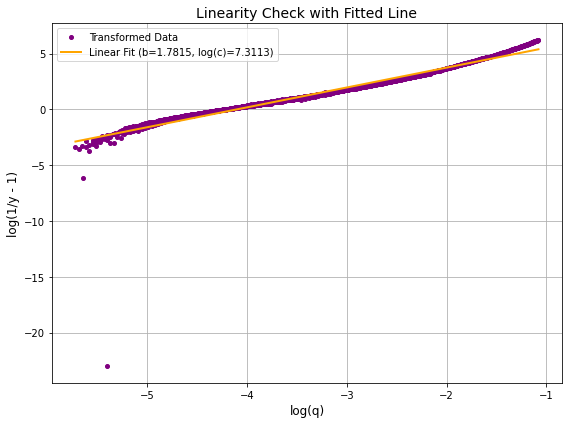

In [4]:

# Define the fitting function
def fit_function(x, a, b, c):
    return a / (1 + (c * x)**b)

# Combine all scaled data into a single dataset for fitting
def combine_scaled_data(scaled_curves):
    """
    Combine all scaled curves into a single dataset, ensuring only positive x and y values are included.
    """
    all_x, all_y = [], []
    for scaled_x, scaled_y in scaled_curves:
        valid_indices = (scaled_x > 0) & (scaled_y > 0)  # Ensure x > 0 and y > 0
        all_x.extend(scaled_x[valid_indices])
        all_y.extend(scaled_y[valid_indices])
    return np.array(all_x), np.array(all_y)

# Combine the scaled data
combined_x, combined_y = combine_scaled_data(scaled_curves)
# Debug: Check data ranges
print(f"Combined X Range: {combined_x.min()} to {combined_x.max()}")
print(f"Combined Y Range: {combined_y.min()} to {combined_y.max()}")

# Normalize y for better numerical stability
normalized_y = combined_y / np.max(combined_y)

# Add a small epsilon to avoid infinities in the transformation
epsilon = 1e-10
normalized_y = np.clip(normalized_y, epsilon, 1 - epsilon)

# Calculate log(1/y - 1) and log(x)
transformed_y = np.log(1 / normalized_y - 1)
log_x = np.log(combined_x)

# Debug: Check transformed data
print(f"Transformed Y Range: {transformed_y.min()} to {transformed_y.max()}")
print(f"Log X Range: {log_x.min()} to {log_x.max()}")

# Fit a linear model to log(1/y - 1) vs log(x)
def linear_model(x, m, c):
    return m * x + c

popt, pcov = curve_fit(linear_model, log_x, transformed_y)
b_fixed, log_c_fixed = popt  # Slope and intercept
c_fixed = np.exp(log_c_fixed)  # Convert log(c) to c
print(f"Linear Fit Parameters: slope (b) = {b_fixed:.4f}, log(c) = {log_c_fixed:.4f}, c = {c_fixed:.4e}")

# Generate the fitted line
fitted_line = linear_model(log_x, b_fixed, log_c_fixed)

# Plot the linearity check with fitted line
plt.figure(figsize=(8, 6))
plt.plot(log_x, transformed_y, 'o', label='Transformed Data', color='purple', markersize=4)
plt.plot(log_x, fitted_line, label=f'Linear Fit (b={b_fixed:.4f}, log(c)={log_c_fixed:.4f})', color='orange', linewidth=2)
plt.xlabel('log(q)', fontsize=12)
plt.ylabel('log(1/y - 1)', fontsize=12)
plt.title('Linearity Check with Fitted Line', fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Fitted parameters: a = 0.1485, b = 2.0428, c = 4.0140e+01
Fitted Y Range: 0.0007118705577200248 to 0.14617567092823544


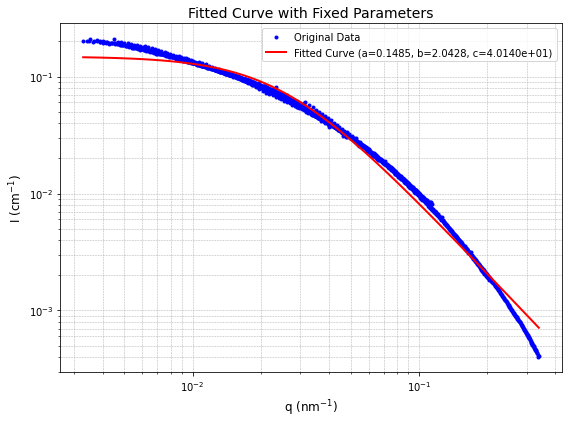

In [5]:
# Log-transformed version for stability
def log_fit_function(x, log_a, b, c):
    return log_a - np.log1p((c * x) ** b)

# Combine the scaled data
combined_x, combined_y = combine_scaled_data(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = combined_x > 0
filtered_x = combined_x[valid_indices]
filtered_y = combined_y[valid_indices]

# Convert y to log space for better numerical stability
log_y = np.log(filtered_y)

# Fit using log-transformed function
popt, pcov = curve_fit(
    log_fit_function, filtered_x, log_y, 
    p0=[0, 1, 1], bounds=([-np.inf, 0, 0], [np.inf, 5, np.inf]), maxfev=5000
)

# Extract parameters
log_a_fit, b_fit, c_fit = popt
a_fit = np.exp(log_a_fit)  # Convert back to original scale

print(f"Fitted parameters: a = {a_fit:.4f}, b = {b_fit:.4f}, c = {c_fit:.4e}")

# Generate fitted curve
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = fit_function(extended_x, a_fit, b_fit, c_fit)

# Debug: Check fitted curve ranges
print(f"Fitted Y Range: {fitted_y.min()} to {fitted_y.max()}")

# Plot original data and fitted curve
plt.figure(figsize=(8, 6))
plt.loglog(filtered_x, filtered_y, 'o', label='Original Data', color='blue', markersize=3)
plt.loglog(extended_x, fitted_y, label=f'Fitted Curve (a={a_fit:.4f}, b={b_fit:.4f}, c={c_fit:.4e})', color='red', linewidth=2)

# Add labels, legend, and grid
plt.xlabel('q ($\mathdefault{nm^{-1}}$)', fontsize=12)
plt.ylabel('I (cm$^\mathdefault{-1}$)', fontsize=12)
plt.title('Fitted Curve with Fixed Parameters', fontsize=14)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


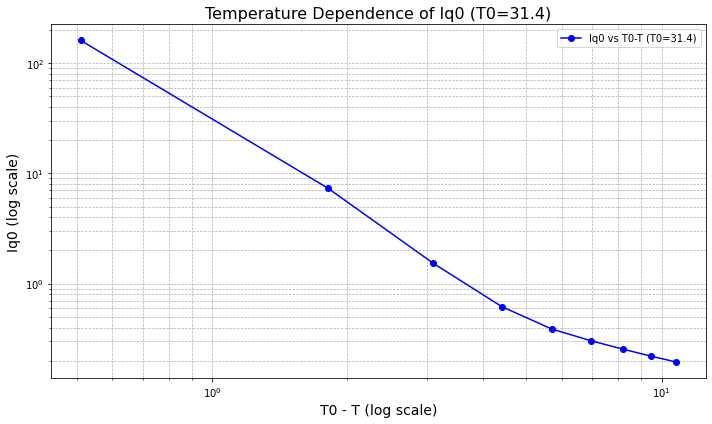

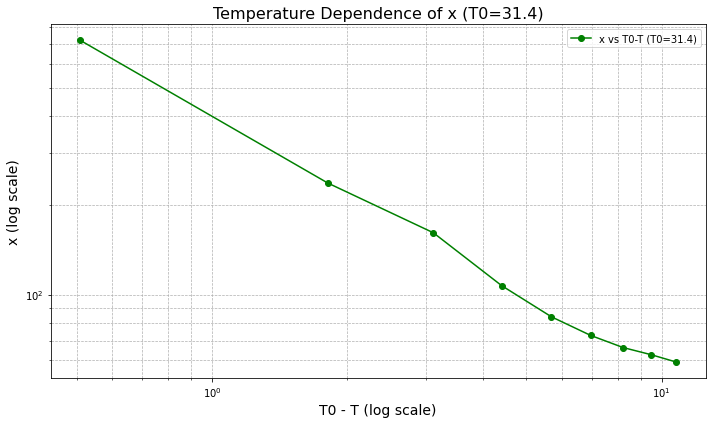

In [6]:
t = []
for avg_dict in avg_ramp_up:
    t.append(np.nanmean(avg_dict['temperature']))
temperatures = t[:-1]
temperatures = np.array(temperatures)
# Function to preprocess data and retain valid indices
def preprocess_data_with_indices(avg_data_list, ql_sta):
    cleaned_data_list = []
    cleaned_ql_sta = []
    valid_indices = []

    for idx, curve in enumerate(avg_data_list[:-1]):
        q = ql_sta
        i = curve['saxs_1d']
        valid_indices_curve = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices_curve]
        cleaned_i = i[valid_indices_curve]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})
            valid_indices.append(idx)

    return cleaned_data_list, cleaned_ql_sta, valid_indices

# Preprocess the data and get valid indices
avg_ramp_up_cleaned, ql_sta_cleaned, valid_indices = preprocess_data_with_indices(avg_ramp_up, ql_sta)


# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']
    try:
        popt, _ = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))
    except RuntimeError:
        pass

# Ensure temperatures and fitted parameters are aligned
if len(fitted_parameters) != len(temperatures):
    raise ValueError("Mismatch between fitted parameters and temperature list!")
# Explore different T0 values
T0_values = [31.4]
for T0 in T0_values:
    T_diff = T0 - temperatures  # Ensure a single array
    Iq0_values = [param[0] for param in fitted_parameters]
    x_values = [param[1] for param in fitted_parameters]

    # Save data to CSV
    output_filename = f"scaling_coefficients_T0_{T0:.1f}.csv"

    # Plot Iq0 vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, Iq0_values, 'o-', color='blue', label=f'Iq0 vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('Iq0 (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of Iq0 (T0={T0:.1f})', fontsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot x vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, x_values, 'o-', color='green', label=f'x vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('x (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of x (T0={T0:.1f})', fontsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()
